Implement a multi-layered classifier where weights of each layer is calculated greedily using
layer-wise pretraining with the help of auto-encoders on STL-10 dataset. Train a classifier having
X structure (excluding input and output layers) for classification task on the test set.
1. Report the classification accuracy on the test set and plot loss curves on the training and
evaluation set.
2. Report the class-wise accuracy of each class.
3. Plot t-sne for this model (use embeddings from layer X[3]) . Use the first 500 images of
each class from the test dataset for this visualization.
X = [1024,1200,728,512,128], if last digit of your roll no. is odd
X = [1024,1000,500,256, 128,64], if last digit of your roll no. is even
Reference - Slides [page number 11 to 14]

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms,models
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
from sklearn import metrics

In [10]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

traindataset = datasets.STL10('../downloads/', download=True, split='train', transform=transform)
testdataset = datasets.STL10('../downloads/', download=True, split='test', transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
print(f'traindataset =>{traindataset.data.shape}')
print(f'testdataset =>{testdataset.data.shape}')

traindataset =>(5000, 3, 96, 96)
testdataset =>(8000, 3, 96, 96)


In [12]:

trainloader = torch.utils.data.DataLoader(traindataset, batch_size=100, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=1000, shuffle=False, num_workers=4)

torch.Size([1000, 1, 96, 96])


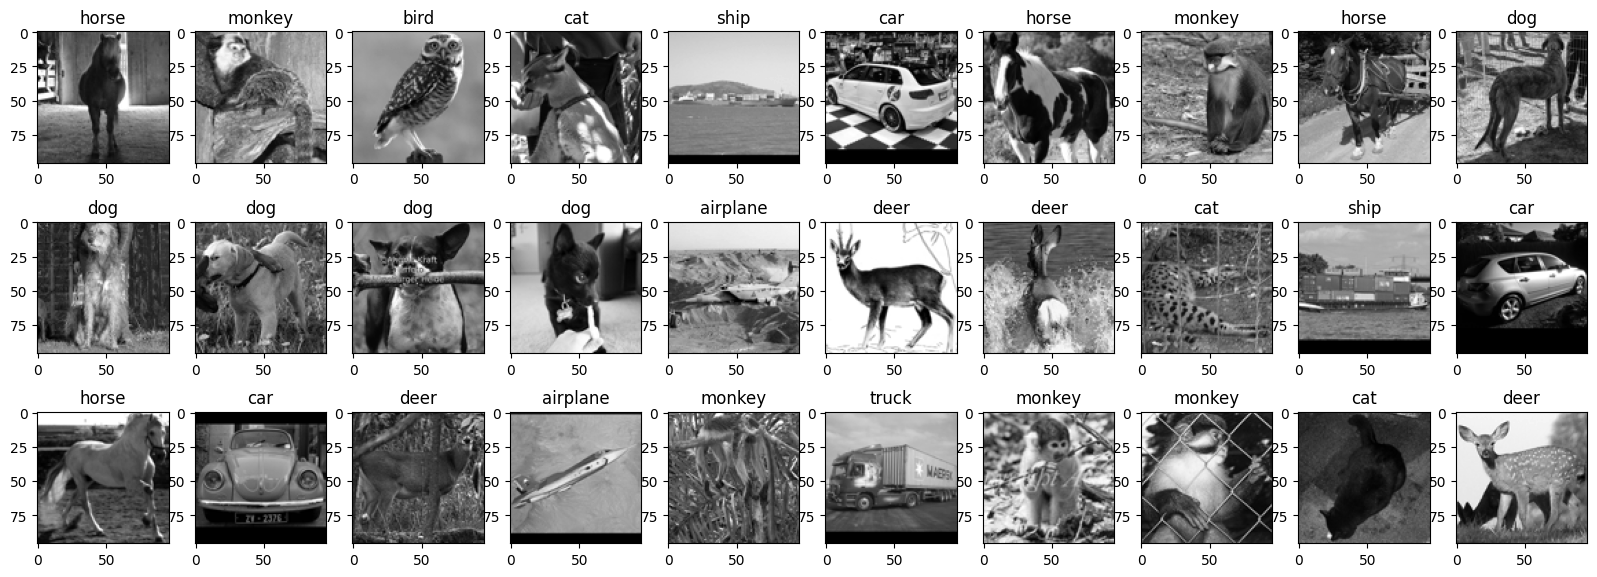

In [18]:
def view_samples():
    
    test_images, labels = next(iter(testloader))
    print(test_images.shape)
    fig = plt.figure(figsize =(20,7))
    nrows = 3
    ncols = 10
    b=np.random.randint(0,test_images.shape[0]-nrows*ncols)
    for i in range(nrows*ncols):
        plot = fig.add_subplot(nrows, ncols, i+1)
        plot.set_title(testdataset.classes[labels[i+b].cpu().numpy()])
        plot.imshow(np.transpose(test_images[i+b], (1, 2, 0)).cpu(),cmap='gray')
    plt.show()
view_samples()

In [19]:
def plot_training_graphs(loss_list):
    fig = plt.figure(figsize =(20,7))
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title("Training vs Validation loss")
    plot.plot(loss_list[:,0], linestyle='--', label="Training Loss")
    plot.plot(loss_list[:,1], linestyle='-', label="Validation Loss" )
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Loss")
    plot.legend()
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title("Training vs Validation Accuracy")
    plot.plot(loss_list[:,2], linestyle='--', label="Training Accuracy")
    plot.plot(loss_list[:,3], linestyle='-', label="Validation Accuracy" )
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Accuracy")
    plot.legend()
    plt.show()

In [25]:
# Train the model
def auto_encoder_model_training(model,criterion,optimizer,trainloader,testloader,num_epochs = 10):
    loss_list = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        for images, _ in trainloader:
            # Forward pass
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            loss = criterion(outputs, images)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*images.size(0)
            #train_acc += metrics.accuracy_score(labels,outputs.argmax(axis=1))
        # Evaluate the model on the validation set
        with torch.no_grad():
            images, _ = next(iter(testloader))
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()*images.size(0)
            #val_acc += metrics.accuracy_score(labels,outputs.argmax(axis=1))
        train_loss = train_loss/len(trainloader)
        #val_loss = val_loss/len(testloader)
        train_acc = train_acc/len(trainloader)
        #val_acc = val_acc/len(testloader)
        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}, \tTest Loss: {val_loss:.6f},  \tTraining acc: {train_acc:.6f}, \tTest acc: {val_acc:.6f}, ')
        loss_list.append([train_loss,val_loss,train_acc,val_acc])
    
    
    return np.array(loss_list)


In [38]:
# Train the model
def model_training(model,criterion,optimizer,trainloader,testloader,num_epochs = 10):
    loss_list = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        for images, labels in trainloader:
            # Forward pass
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*images.size(0)
            train_acc += metrics.accuracy_score(labels,outputs.argmax(axis=1))
        # Evaluate the model on the validation set
        with torch.no_grad():
            images, labels = next(iter(testloader))
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()*images.size(0)
            val_acc += metrics.accuracy_score(labels,outputs.argmax(axis=1))
        train_loss = train_loss/len(trainloader)
        #val_loss = val_loss/len(testloader)
        train_acc = train_acc/len(trainloader)
        #val_acc = val_acc/len(testloader)
        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}, \tTest Loss: {val_loss:.6f},  \tTraining acc: {train_acc:.6f}, \tTest acc: {val_acc:.6f}, ')
        loss_list.append([train_loss,val_loss,train_acc,val_acc])
    
    
    return np.array(loss_list)


In [26]:
from sklearn import metrics
import seaborn as sns
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})

def confusionMatrixAndAccuracyReport(Y_test, Y_pred_probs, label):
    Y_pred = Y_pred_probs.argmax(axis=1)
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = metrics.accuracy_score(Y_test, Y_pred)

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    top_5_accuracy = metrics.top_k_accuracy_score(Y_test,Y_pred_probs,k=5,labels=np.arange(10))

    plt.figure(figsize=(10, 10))
    plt.title(f'Top 1 Accuracy : {overallAccuracy*100:3.2f}% | Top 5 Accuracy : {top_5_accuracy*100:3.2f}% ', size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues', fmt='g')

    plt.show()
    print(f'Top 1 Accuracy: {overallAccuracy*100:3.3f}%')
    print(f'Top 5 Accuracy: {top_5_accuracy*100}%')
    print(f'Classwise Accuracy Score: \n{classwiseAccuracy}')

X = [1024,1200,728,512,128], as last digit of your roll no. is odd

In [27]:
class autoencoder(nn.Module):
    input_size = 96*96
    hidden_sizes = [1024,1200,728,512]
    output_size = 128
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(self.input_size, self.hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[1], self.hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[2], self.hidden_sizes[3]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[3], self.output_size))
        self.decoder = nn.Sequential(nn.Linear(self.output_size, self.hidden_sizes[3]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[3], self.hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[2], self.hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[1], self.hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[0], self.input_size),
                      nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
vanila_ae = autoencoder()
print(vanila_ae)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=728, bias=True)
    (5): ReLU()
    (6): Linear(in_features=728, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=728, bias=True)
    (3): ReLU()
    (4): Linear(in_features=728, out_features=1200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1200, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=9216, bias=True)
    (9): Sigmoid()
  )
)


Epoch: 1 	Training Loss: 5.901518, 	Test Loss: 52.402195,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 2 	Training Loss: 5.074501, 	Test Loss: 50.662979,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 3 	Training Loss: 4.991051, 	Test Loss: 50.725631,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 4 	Training Loss: 5.125215, 	Test Loss: 53.065300,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 5 	Training Loss: 4.600117, 	Test Loss: 43.165594,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 6 	Training Loss: 4.289328, 	Test Loss: 43.102488,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 7 	Training Loss: 4.271473, 	Test Loss: 42.751934,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 8 	Training Loss: 4.252569, 	Test Loss: 42.610187,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 9 	Training Loss: 4.242734, 	Test Loss: 42.326067,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 10 	Training Loss: 4.184287, 	Test Loss

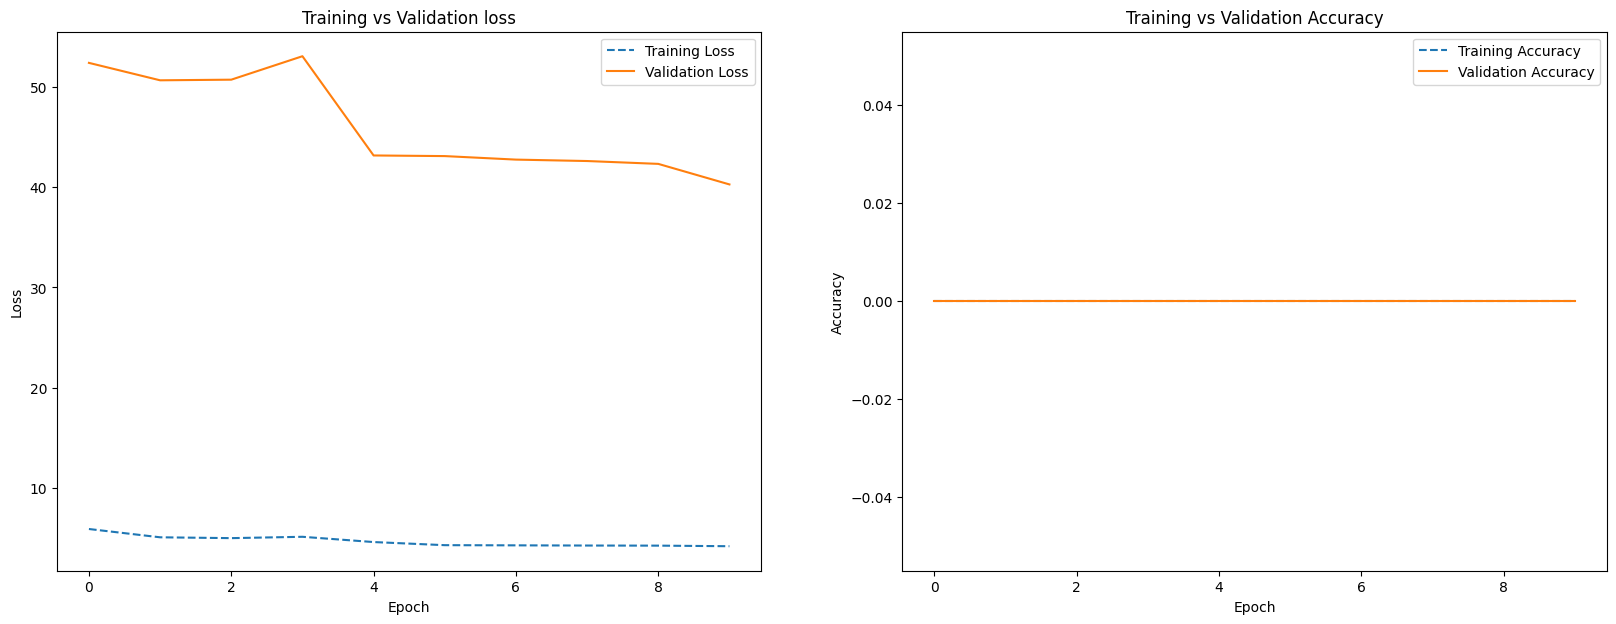

In [28]:
criterion = nn.MSELoss()
optimizer =  torch.optim.Adam(vanila_ae.parameters(), lr=0.001)

In [31]:
loss_list = auto_encoder_model_training(vanila_ae,criterion,optimizer,trainloader,testloader,num_epochs=50)
plot_training_graphs(loss_list)

Epoch: 1 	Training Loss: 3.856977, 	Test Loss: 37.513398,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 2 	Training Loss: 3.721473, 	Test Loss: 36.921877,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 3 	Training Loss: 3.696816, 	Test Loss: 36.712512,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 4 	Training Loss: 3.670479, 	Test Loss: 36.495462,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 5 	Training Loss: 3.657364, 	Test Loss: 36.705106,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 6 	Training Loss: 3.658935, 	Test Loss: 36.474269,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 7 	Training Loss: 3.642116, 	Test Loss: 36.561713,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 8 	Training Loss: 3.649646, 	Test Loss: 36.653612,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 9 	Training Loss: 3.636813, 	Test Loss: 36.141180,  	Training acc: 0.000000, 	Test acc: 0.000000, 
Epoch: 10 	Training Loss: 3.632114, 	Test Loss

KeyboardInterrupt: 

For visualising AE performance

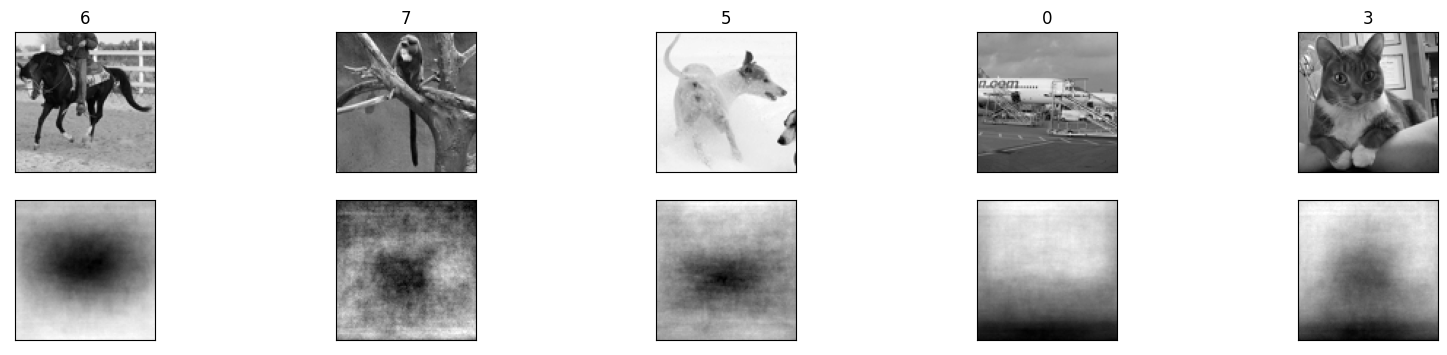

In [32]:
images, labels = next(iter(testloader))

img = images[0].view(1, 96*96)
with torch.no_grad():
    encoded = vanila_ae.encoder(images.view(-1, 96*96))
    decoded = vanila_ae.decoder(encoded)

plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(96, 96))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(labels[i].numpy())
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded[i].reshape(96, 96))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [35]:
class image_classifier(nn.Module):
    num_classes = 10
    def __init__(self):
        super(image_classifier, self).__init__()
        self.fc = nn.Sequential(nn.Linear(vanila_ae.output_size, self.num_classes),
                      nn.ReLU())

    def forward(self, x):
        x = vanila_ae.encoder(x)
        x = self.fc(x)
        return x
image_clf = image_classifier()
print(image_clf)

image_classifier(
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
    (1): ReLU()
  )
)


In [36]:
criterion_clf = nn.CrossEntropyLoss()
optimizer_clf =  torch.optim.Adam(image_clf.parameters(), lr=0.001)

Epoch: 1 	Training Loss: 227.092481, 	Test Loss: 2242.440462,  	Training acc: 0.148400, 	Test acc: 0.181000, 
Epoch: 2 	Training Loss: 222.574184, 	Test Loss: 2208.585501,  	Training acc: 0.184600, 	Test acc: 0.198000, 
Epoch: 3 	Training Loss: 219.737198, 	Test Loss: 2182.567835,  	Training acc: 0.195200, 	Test acc: 0.207000, 
Epoch: 4 	Training Loss: 217.439372, 	Test Loss: 2161.852121,  	Training acc: 0.203200, 	Test acc: 0.214000, 
Epoch: 5 	Training Loss: 215.794990, 	Test Loss: 2147.725105,  	Training acc: 0.211000, 	Test acc: 0.222000, 
Epoch: 6 	Training Loss: 214.547136, 	Test Loss: 2137.302399,  	Training acc: 0.217600, 	Test acc: 0.221000, 
Epoch: 7 	Training Loss: 213.586226, 	Test Loss: 2128.893852,  	Training acc: 0.216600, 	Test acc: 0.223000, 
Epoch: 8 	Training Loss: 212.785511, 	Test Loss: 2121.552229,  	Training acc: 0.223400, 	Test acc: 0.225000, 
Epoch: 9 	Training Loss: 212.127317, 	Test Loss: 2115.935326,  	Training acc: 0.222000, 	Test acc: 0.230000, 
Epoch: 10 

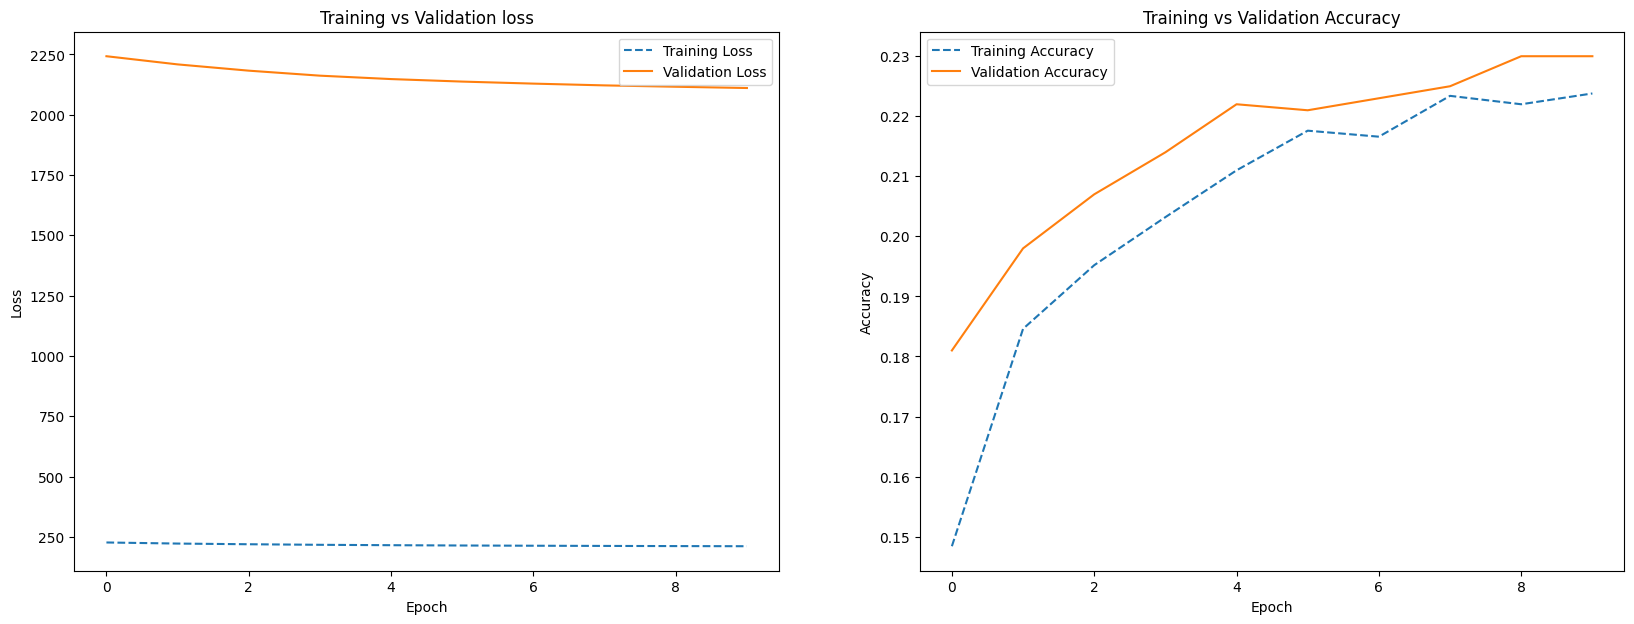

In [40]:
loss_list = model_training(image_clf,criterion_clf,optimizer_clf,trainloader,testloader,num_epochs=10)
plot_training_graphs(loss_list)

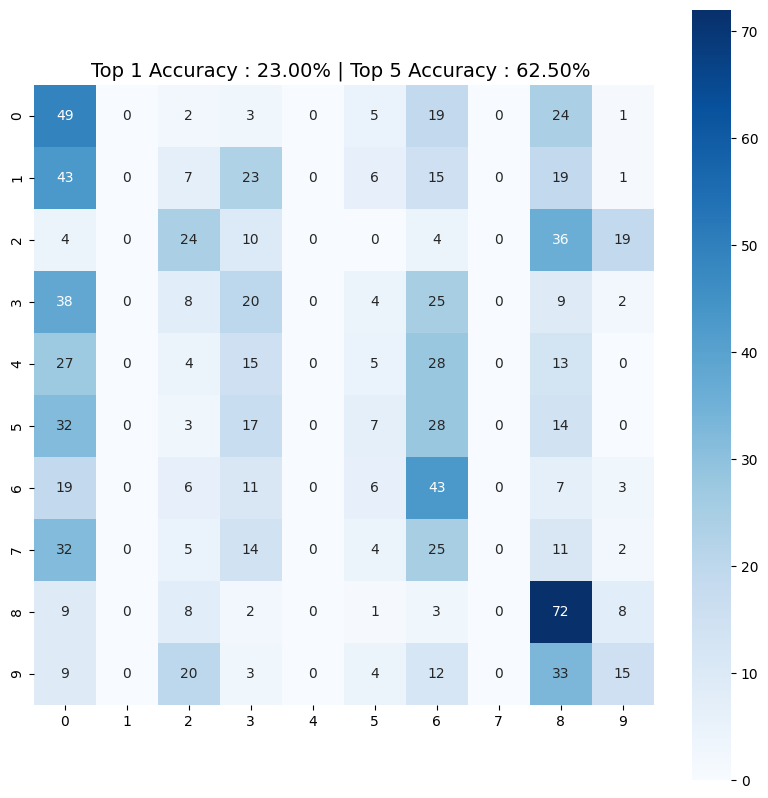

Top 1 Accuracy: 23.000%
Top 5 Accuracy: 62.5%
Classwise Accuracy Score: 
[0.47572816 0.         0.24742268 0.18867925 0.         0.06930693
 0.45263158 0.         0.69902913 0.15625   ]


In [42]:
test_images, test_labels = next(iter(testloader))
test_output = image_clf(test_images.view(-1, 96*96))
with torch.no_grad():
    confusionMatrixAndAccuracyReport(test_labels,test_output,testdataset.classes)